In [1]:
import re
import os
import warnings
from datetime import date, datetime, timedelta
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
pd.options.display.max_columns = None
warnings.filterwarnings("ignore")

## Data import

In [43]:
df = pd.read_csv('data/survey_results_public.csv')
df_schema = pd.read_csv('data/survey_results_schema.csv')

In [10]:
df_schema.head(10)

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."
5,EmploymentStatus,Which of the following best describes your cur...
6,FormalEducation,Which of the following best describes the high...
7,MajorUndergrad,Which of the following best describes your mai...
8,HomeRemote,How often do you work from home or remotely?
9,CompanySize,"In terms of the number of employees, how large..."


In [8]:
df.head(2)

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stac...,9.0,Desktop; iOS app,At leas

In [6]:
for i, col in enumerate(df.columns): print(i, col)

0 Respondent
1 Professional
2 ProgramHobby
3 Country
4 University
5 EmploymentStatus
6 FormalEducation
7 MajorUndergrad
8 HomeRemote
9 CompanySize
10 CompanyType
11 YearsProgram
12 YearsCodedJob
13 YearsCodedJobPast
14 DeveloperType
15 WebDeveloperType
16 MobileDeveloperType
17 NonDeveloperType
18 CareerSatisfaction
19 JobSatisfaction
20 ExCoderReturn
21 ExCoderNotForMe
22 ExCoderBalance
23 ExCoder10Years
24 ExCoderBelonged
25 ExCoderSkills
26 ExCoderWillNotCode
27 ExCoderActive
28 PronounceGIF
29 ProblemSolving
30 BuildingThings
31 LearningNewTech
32 BoringDetails
33 JobSecurity
34 DiversityImportant
35 AnnoyingUI
36 FriendsDevelopers
37 RightWrongWay
38 UnderstandComputers
39 SeriousWork
40 InvestTimeTools
41 WorkPayCare
42 KinshipDevelopers
43 ChallengeMyself
44 CompetePeers
45 ChangeWorld
46 JobSeekingStatus
47 HoursPerWeek
48 LastNewJob
49 AssessJobIndustry
50 AssessJobRole
51 AssessJobExp
52 AssessJobDept
53 AssessJobTech
54 AssessJobProjects
55 AssessJobCompensation
56 AssessJob

## Business questions:  
We will try to answer to the following questions:  
> **1. Which roles give more satisfaction in the development field?**  
> **2. What are the main causes for leaving the development field?**  
> **3. What are the main profiles for people who posts on StackOverflow?**

<br>

## 1. Which roles give more satisfaction in the development field?

Lets first indentify where and how the information about the roles are stored:

In [4]:
# Columns wich describe the role as developer
role_columns = [
    'DeveloperType',
    'WebDeveloperType',
    'MobileDeveloperType',
    'NonDeveloperType'
]

In [14]:
for role in role_columns:
    print(role)
    print(df[role].value_counts())
    print()
    print()

DeveloperType
Web developer                                                                                                                                                                                          10683
Web developer; Desktop applications developer                                                                                                                                                           1849
Mobile developer                                                                                                                                                                                        1556
Web developer; Mobile developer                                                                                                                                                                         1503
Desktop applications developer                                                                                                                                        

**Almost all these columns need to be preprocessed in order to get  
useful informations from them, because the data they store is highly  
unstructured.**

Let's write a function to preprocess these columns:

In [5]:
def analyse_column(df, col, recreate_column=True, column_distribution=True):
    """This function can reclassify a column stored as strings with
    multiple informations chained.
    
    Parameters
    ------------
    df : pandas.DataFrame
      The dataframe with the column to be analysed.
    
    col : str
      The name of the column in df.
      
    recreate_column : bool (default False)
      If True, df will be returned with the column col as lists
    
    column_distribution : bool (default False)
      If True, a frequency distribution of col wil be returned
    
    Returns
    ------------
    if recreate_column=True and column_distribution=True:
      (df, distribution), where df : pandas.DataFrame and
                                distribution : pandas.Series
                                
    if recreate_column=True and column_distribution=False:
      df : pandas.DataFrame
      
    if recreate_column=False and column_distribution=True:
      distribution : pandas.Series
    """
    
    df = df.copy()
    diz = defaultdict(int)
    new_column = list()
    
    for string in df[col]:
        values = str(string).split(';')
        if column_distribution:
            for val in values:
                diz[val.strip()] += 1
        if recreate_column:
            sublist = []
            for val in values:
                sublist.append(val.strip())
            new_column.append(sublist)
        
    if recreate_column:
        df[col] = new_column
        if column_distribution:
            return (df, pd.Series(diz))
        else:
            return df
    else:
        if column_distribution:
            return pd.Series(diz)
        else:
            return None

Let's show the distribution for the DeveloperType column, and then  
we'll subsitute the original column with a new column of lists.

In [44]:
developer_type_dist = analyse_column(df, 'DeveloperType', recreate_column=False, column_distribution=True)
developer_type_dist.sort_values(inplace=True, ascending=False)
developer_type_dist

Web developer                                            26235
nan                                                      15267
Desktop applications developer                           10435
Mobile developer                                          8326
Database administrator                                    5192
Developer with a statistics or mathematics background     4091
Systems administrator                                     4086
DevOps specialist                                         4015
Embedded applications/devices developer                   3352
Data scientist                                            3045
Other                                                     2694
Graphics programming                                      1731
Graphic designer                                          1426
Machine learning specialist                               1379
Quality assurance engineer                                1252
dtype: int64

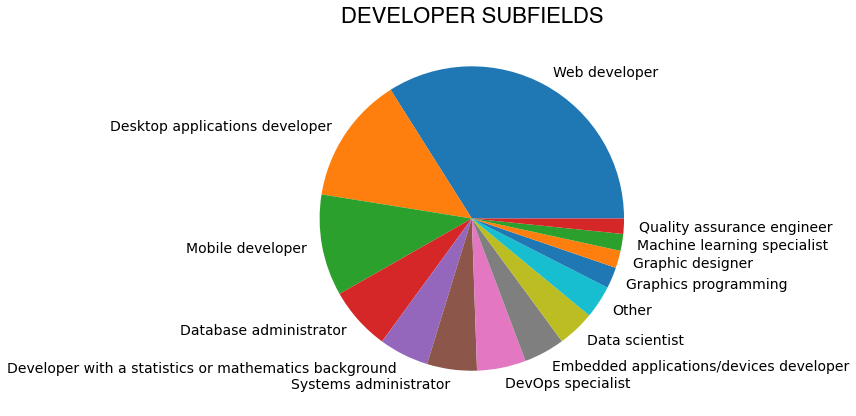

In [61]:
fig, ax = plt.subplots(figsize=(13, 7))
developer_type_dist_nonna = (
    developer_type_dist[developer_type_dist.index != 'nan'])
ax.pie(developer_type_dist_nonna,
       labels=developer_type_dist_nonna.index,
       textprops={'size': 14})
ax.set_title("DEVELOPER SUBFIELDS",
             size=22,
             y=1.0,
             fontdict={'family': 'Helvetica'},
             fontweight='bold')
#fig.tight_layout()
fig.savefig('plots/developers subfields.png')
plt.show()

In [45]:
# Just to show how this function works

df2 = analyse_column(df, 'DeveloperType', recreate_column=True,
                     column_distribution=False)
print(df['DeveloperType'][4])
df2['DeveloperType'][4]

Mobile developer; Graphics programming; Desktop applications developer


['Mobile developer', 'Graphics programming', 'Desktop applications developer']

In [46]:
df = analyse_column(df, 'DeveloperType', recreate_column=True,
                    column_distribution=False)

In [47]:
# If you want to look at the other columns

role_columns = [
    'DeveloperType',
    'WebDeveloperType',
    'MobileDeveloperType',
    'NonDeveloperType'
]

another_column_dist = analyse_column(df, 'NonDeveloperType', recreate_column=False, column_distribution=True)
another_column_dist.sort_values(inplace=True, ascending=False)
another_column_dist

nan                           46502
Analyst or consultant          1897
Other                          1558
Data scientist                 1100
Educator or academic            732
Designer or illustrator         600
Product manager                 365
C-suite executive               257
Marketing or sales manager      152
Elected official                 34
dtype: int64

In [60]:
# Just to look at the other variables when NonDeveloperType is non-null

df.loc[~df['NonDeveloperType'].isna(), ['DeveloperType',
                                        'WebDeveloperType',
                                        'MobileDeveloperType',
                                        'NonDeveloperType']].head(10)

,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType
3,NaN,NaN,NaN,Data scientist
6,NaN,NaN,NaN,Data scientist
10,NaN,NaN,NaN,Other
28,NaN,NaN,NaN,C-suite executive; Product manager
29,NaN,NaN,NaN,Other
40,NaN,NaN,NaN,Educator or academic
55,NaN,NaN,NaN,Other
60,NaN,NaN,NaN,Other
139,NaN,NaN,NaN,C-suite executive
153,NaN,NaN,NaN,Analyst or consultant


In [61]:
# Just to look at the other variables when MobileDeveloperType is non-null

df.loc[~df['MobileDeveloperType'].isna(), ['DeveloperType',
                                        'WebDeveloperType',
                                        'MobileDeveloperType',
                                        'NonDeveloperType']].head(10)

,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType
57,Mobile developer,NaN,Android,NaN
86,Mobile developer,NaN,iOS,NaN
108,Mobile developer,NaN,Windows Phone,NaN
176,Mobile developer,NaN,iOS,NaN
189,Mobile developer,NaN,iOS,NaN
221,Mobile developer,NaN,Android,NaN
252,Mobile developer,NaN,iOS,NaN
291,Mobile developer,NaN,iOS,NaN
319,Mobile developer,NaN,Android,NaN
336,Mobile developer,NaN,Android,NaN


In [62]:
# Just to look at the other variables when WebDeveloperType is non-null

df.loc[~df['WebDeveloperType'].isna(), ['DeveloperType',
                                        'WebDeveloperType',
                                        'MobileDeveloperType',
                                        'NonDeveloperType']].head(10)

,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType
7,Web developer,Full stack Web developer,NaN,NaN
11,Web developer,Back-end Web developer,NaN,NaN
13,Web developer,Full stack Web developer,NaN,NaN
16,Web developer,Full stack Web developer,NaN,NaN
18,Web developer,Full stack Web developer,NaN,NaN
20,Web developer,Full stack Web developer,NaN,NaN
23,Web developer,Full stack Web developer,NaN,NaN
25,Web developer,Back-end Web developer,NaN,NaN
33,Web developer,Full stack Web developer,NaN,NaN
37,Web developer,Full stack Web developer,NaN,NaN


**Let's concentrate on the column DeveloperType, and its relation with  
job satisfaction.**

Whan looking at the **_job satisfaction_**, we could use either of the following two columns:

In [66]:
df['CareerSatisfaction'].value_counts(sort=False).sort_index()

0.0       392
1.0       211
2.0       495
3.0      1046
4.0      1352
5.0      3070
6.0      4721
7.0      9384
8.0     11037
9.0      5579
10.0     5408
Name: CareerSatisfaction, dtype: int64

In [67]:
df['JobSatisfaction'].value_counts(sort=False).sort_index()

0.0      467
1.0      373
2.0      888
3.0     1635
4.0     1865
5.0     3749
6.0     4726
7.0     7969
8.0     8983
9.0     5573
10.0    4148
Name: JobSatisfaction, dtype: int64

Let's caluclate the Pearson's correlation coefficient between  
CareerSatisfaction and JobSatisfaction and let's show their  
relationship also grafically.  
I will expect a strong relationship, so using either one of these  
two features would be quite the same for our purpose.

In [10]:
# Pearson's correlation coefficient

df_temp = df.dropna(subset=['CareerSatisfaction', 'JobSatisfaction'])
cor = np.corrcoef(df_temp['CareerSatisfaction'],
                  df_temp['JobSatisfaction'])
print("The Pearson's correlation coefficient is: {}".format(round(cor[0, 1], 2)))

The Pearson's correlation coefficient is: 0.65


C:\Users\Utente\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


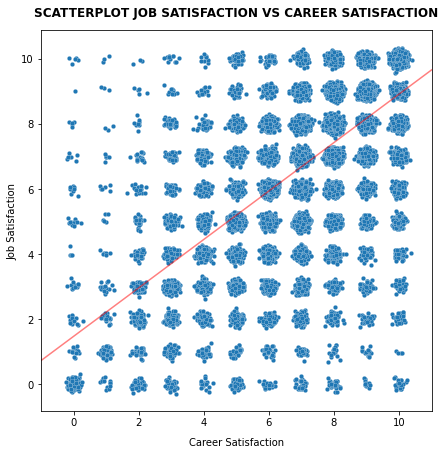

In [11]:
# Let's show the relationship between these two variables.
# We must use a little trick to better visualize this plot,
# because both these features have ordinal values, 0 to 10.
# We'll add little normal shifts from these values (jitter),
# so the values don't overlap.

df_temp = df.dropna(subset=['CareerSatisfaction', 'JobSatisfaction'])
gen = np.random.RandomState(42)
df_temp.loc[:, 'CareerSatisfaction'] = df_temp['CareerSatisfaction'] + gen.normal(0, .1, df_temp.shape[0])
df_temp.loc[:, 'JobSatisfaction'] = df_temp['JobSatisfaction'] + gen.normal(0, .1, df_temp.shape[0])

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(df_temp['CareerSatisfaction'],
            df_temp['JobSatisfaction'], s=20, edgecolors='w', linewidths=0.2)
ax.set_title('SCATTERPLOT JOB SATISFACTION VS CAREER SATISFACTION',
             fontweight='bold',
             y=1.02)
ax.set_xlabel('Career Satisfaction', labelpad=10)
ax.set_ylabel('Job Satisfaction')
ax.set_xlim(-1, 11)

# To plot the interpolation line
lr = LinearRegression()
lr.fit(df_temp['CareerSatisfaction'].values.reshape(-1, 1), df_temp['JobSatisfaction'])
xx = np.linspace(-1, 11, 200)
yy = lr.predict(xx.reshape(-1, 1))
ax.plot(xx, yy, color='red', alpha=0.5)

plt.show()

This brief analysis shows that, a expected, there is a strong  
correlation between these two variables, so we'll process with  
just **JobSatisfaction**.

In [48]:
print('Entire dataset rows:', df.shape[0])

df2 = df[['JobSatisfaction', 'DeveloperType']].dropna()
print('After removing rows with NAs:', df2.shape[0])

Entire dataset rows: 51392
After removing rows with NAs: 40376


**We can proceed with 40.000 samples.**

Now it's time for us to reclassify the DeveloperType as dummies.  
Because of the coplex structure of this column, we must proceed  
manually.

In [136]:
df2.head(3)

,JobSatisfaction,DeveloperType
2,9.0,[Other]
3,3.0,[nan]
4,8.0,"[Mobile developer, Graphics programming, Deskt..."


In [49]:
# Create the dummies for DeveloperType values
# These dummies must not sum to 1 in a row, because a person can have
# multiple roles at the same time in this dataset.

for val in developer_type_dist.index:
    df2['DeveloperType_' + '_'.join(val.split())] = (
        df2['DeveloperType'].apply(lambda col: 1 if val in col else 0)
    )

df2.drop('DeveloperType', axis=1, inplace=True)

In [32]:
df2.head()

,JobSatisfaction,DeveloperType_Web_developer,DeveloperType_nan,DeveloperType_Desktop_applications_developer,DeveloperType_Mobile_developer,DeveloperType_Database_administrator,DeveloperType_Developer_with_a_statistics_or_mathematics_background,DeveloperType_Systems_administrator,DeveloperType_DevOps_specialist,DeveloperType_Embedded_applications/devices_developer,DeveloperType_Data_scientist,DeveloperType_Other,DeveloperType_Graphics_programming,DeveloperType_Graphic_designer,DeveloperType_Machine_learning_specialist,DeveloperType_Quality_assurance_engineer
2,9.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8.0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0
6,6.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [156]:
# Let's briefly see how many different roles have people here:
df2.iloc[:, 2:].sum(axis=1).value_counts()

1     21644
2      8127
3      5302
4      2793
5      1318
6       626
7       292
8       123
9        64
10       36
13       21
11       15
14        9
12        6
dtype: int64

**Now let's compare the satisfaction levels (mean, median or  
distribution) for every developer role.**  
We have also to find a good and clear graphical reppresentation.

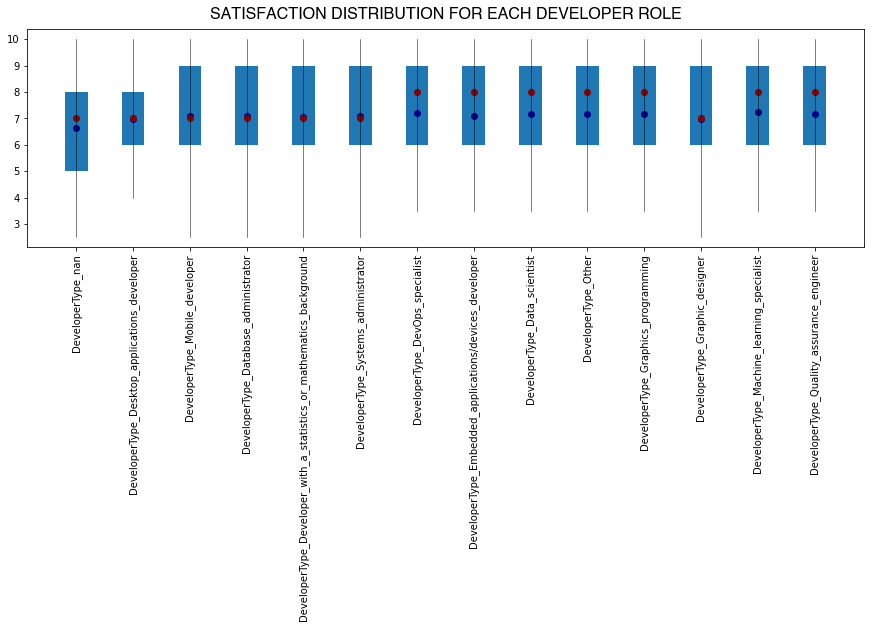

In [99]:
fig, ax = plt.subplots(figsize=(15, 4))

for i, col in enumerate(df2.iloc[:, 2:].columns):
    values = df2.loc[df2[col]==1, 'JobSatisfaction']
    col_mean = values.mean()
    col_median = values.median()
    col_quartile1 = values.quantile(0.25)
    col_quartile3 = values.quantile(0.75)
    IQR = col_quartile3 - col_quartile1
    col_std = values.std()
    
    ax.plot(i, col_mean, marker='o', color='darkblue')
    ax.plot(i, col_median, marker='o', color='darkred')
    ax.add_patch(Rectangle((i - 0.2, col_quartile1), 0.4, IQR))
    ax.plot([i, i], [max(values.min(), col_median - 1.5 * IQR),
                     min(values.max(), col_median + 1.5 * IQR)],
            color='k', linewidth=0.5)

ax.set_xticks(range(len(df2.iloc[:, 2:].columns)))
ax.set_xticklabels(df2.iloc[:, 2:].columns, rotation=90)
ax.set_title('SATISFACTION DISTRIBUTION FOR EACH DEVELOPER ROLE',
             y=1.02, size=16, fontdict={'family': 'Helvetica'})

plt.show()

This first plot is too much technical and not too much clear, because  
our data are ordinal, not continuos, and the quartiles seem to the  
same for every category, so the boxplots. We should concentrate only  
on the means here.

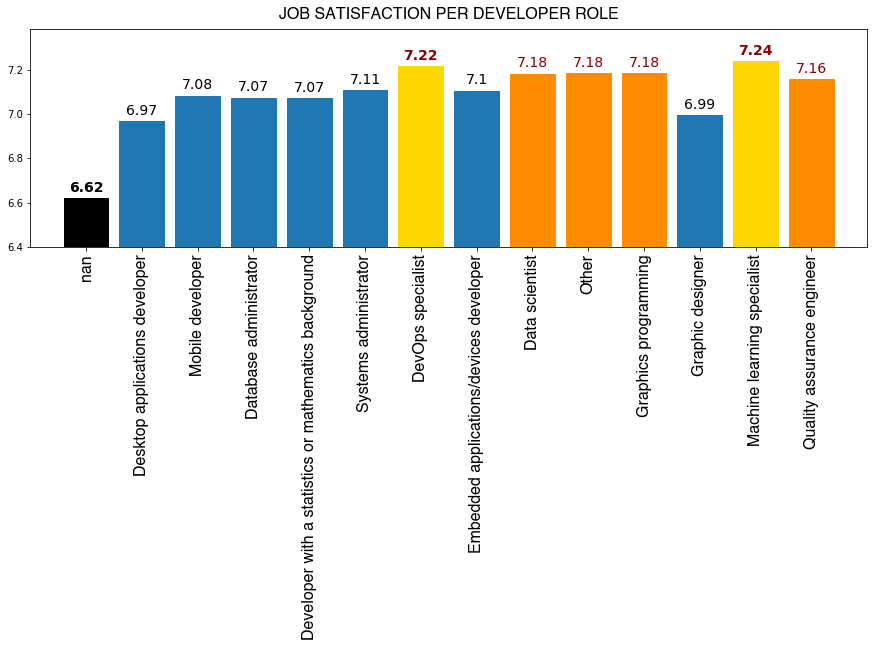

In [21]:
roles_map = {}

fig, ax = plt.subplots(figsize=(15, 4))

xmax, ymax = 0, 0
for i, col in enumerate(df2.iloc[:, 2:].columns):
    values = df2.loc[df2[col]==1, 'JobSatisfaction']
    col_mean = values.mean()
    col_std = values.std()
    if col_mean > 7.2:
        col1 = 'gold'
        col2 = 'darkred'
        weight = 'bold'
    elif col_mean > 7.15:
        col1 = 'darkorange'
        col2 = 'darkred'
        weight = 'normal'
    elif col_mean < 6.7:
        col1 = 'black'
        col2 = 'black'
        weight = 'bold'
    else:
        col1 = 'tab:blue'
        col2 = 'black'
        weight = 'normal'
    ax.add_patch(Rectangle((i - 0.4, 0), 0.8, col_mean,  color=col1))
    ax.text(i, col_mean + 0.03, round(col_mean,2),
            horizontalalignment='center',
            size=14, color=col2, fontdict={'fontweight':weight})
    xmax += 1 
    ymax = max(ymax, col_mean)
    
ax.set_xticks(range(len(df2.iloc[:, 2:].columns)))
xticklabels = [x.replace('DeveloperType_', '').replace('_', ' ') for x in df2.iloc[:, 2:].columns]
ax.set_xticklabels(xticklabels, rotation=90, size=16, fontdict={'family':'Helvetica'})
ax.set_xlim(-1, xmax)
ax.set_ylim(6.4, ymax * 1.02)
ax.set_title('JOB SATISFACTION PER DEVELOPER ROLE', y=1.02,
             fontweight='bold', fontdict={'family':'Helvetica'},
             size=16)
plt.show()

The following picture is just a small variation of the previous one,  
which has been done in order to be pubblished.

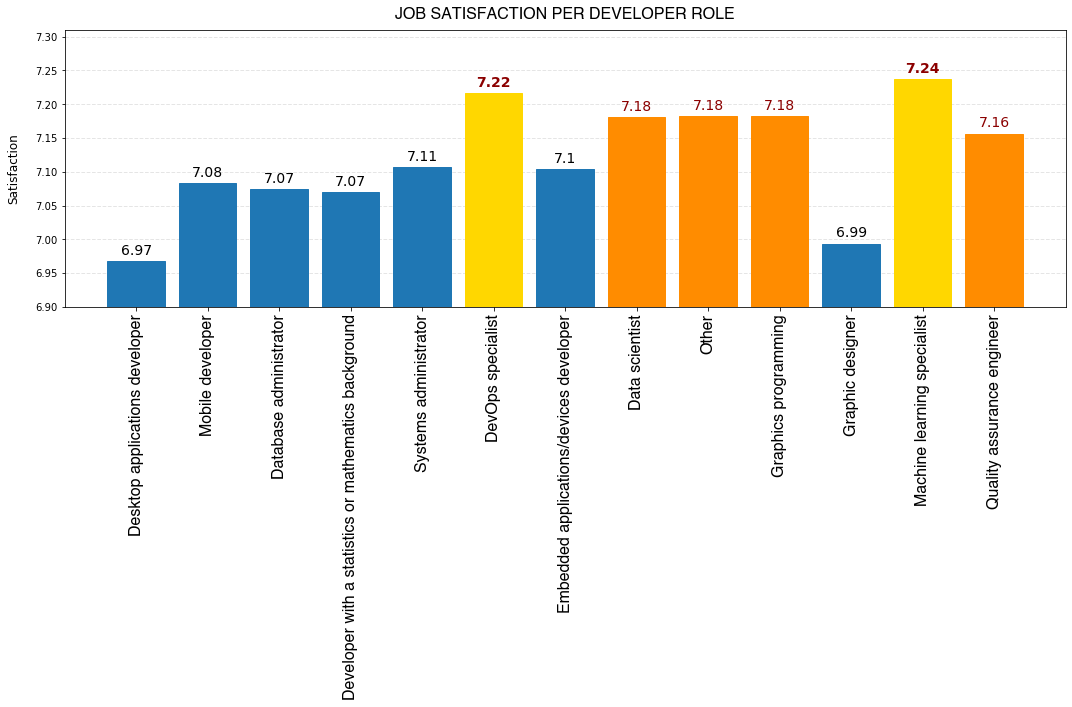

In [55]:
roles_map = {}

fig, ax = plt.subplots(figsize=(15, 10))

xmax, ymax = 0, 0
for i, col in enumerate(df2.iloc[:, 3:].columns):
    values = df2.loc[df2[col]==1, 'JobSatisfaction']
    col_mean = values.mean()
    col_std = values.std()
    if col_mean > 7.2:
        col1 = 'gold'
        col2 = 'darkred'
        weight = 'bold'
    elif col_mean > 7.15:
        col1 = 'darkorange'
        col2 = 'darkred'
        weight = 'normal'
    elif col_mean < 6.7:
        col1 = 'black'
        col2 = 'black'
        weight = 'bold'
    else:
        col1 = 'tab:blue'
        col2 = 'black'
        weight = 'normal'
    ax.add_patch(Rectangle((i - 0.4, 0), 0.8, col_mean,  color=col1))
    ax.text(i, col_mean + 0.01, round(col_mean,2),
            horizontalalignment='center',
            size=14, color=col2, fontdict={'fontweight':weight})
    xmax += 1 
    ymax = max(ymax, col_mean)
    
ax.set_xticks(range(len(df2.iloc[:, 3:].columns)))
xticklabels = [x.replace('DeveloperType_', '').replace('_', ' ') for x in df2.iloc[:, 3:].columns]
ax.set_xticklabels(xticklabels, rotation=90, size=16, fontdict={'family':'Helvetica'})
ax.set_xlim(-1, xmax)
ax.set_ylim(6.9, ymax * 1.01)
ax.set_title('JOB SATISFACTION PER DEVELOPER ROLE', y=1.02,
             fontweight='bold', fontdict={'family':'Helvetica'},
             size=16)
ax.set_ylabel('Satisfaction', labelpad=15, size=12)
for x in np.arange(6, 8, 0.05): ax.axhline(x, color='k', linewidth=1, alpha=0.1, zorder=-1, linestyle='--')
fig.tight_layout()
fig.savefig('plots/job stisfaction.png')
plt.show()

This plot is clear and easy to read.

### Conclusions

The main evidences here are:
- The two developer roles which gives the most satisfaction are:
    1. **Machine Learning Specialist**
    2. **DevOps Specialist**
- Other roles with high satisfaction are:
    1. Data Scientist
    2. Graphics Programming
    3. Quality Assurance Engineer

## 2. What are the main causes for leaving the development field?

To answer to the second question, we need to look at the following variables:
1. ExCoderReturn
2. ExCoderNotForMe
3. ExCoderBalance
4. ExCoder10Years
5. ExCoderBelonged
6. ExCoderSkills
7. ExCoderWillNotCode
8. ExCoderActive

In [56]:
exdeveloper_columns = [
    'ExCoderReturn',
    'ExCoderNotForMe',
    'ExCoderBalance',
    'ExCoder10Years',
    'ExCoderBelonged',
    'ExCoderSkills',
    'ExCoderWillNotCode',
    'ExCoderActive'
]

In [57]:
df3 = df[exdeveloper_columns].dropna(how='all')
df3.head()

,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive
12,Agree,Strongly disagree,Disagree,Strongly disagree,Disagree,Strongly disagree,Disagree,Somewhat agree
46,Agree,Disagree,Agree,Somewhat agree,Strongly disagree,Somewhat agree,Somewhat agree,Agree
197,Somewhat agree,Strongly disagree,Agree,Agree,Strongly disagree,Disagree,Somewhat agree,Disagree
266,Disagree,Strongly agree,Agree,Strongly disagree,Disagree,Disagree,Somewhat agree,Agree
309,Disagree,Somewhat agree,Disagree,Strongly disagree,Strongly agree,Disagree,Agree,Somewhat agree


In [26]:
# We should preprocess these columns as Categorical Type

for col in df3.columns:
    df3[col] = pd.Categorical(df3[col], ordered=True,
                            categories=['Strongly disagree',
                                        'Disagree',
                                        'Somewhat agree',
                                        'Agree',
                                        'Strongly agree'])

### Let's first look at these feature distributions

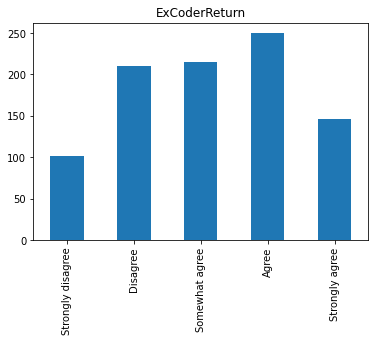

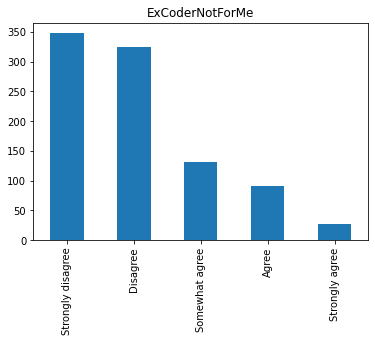

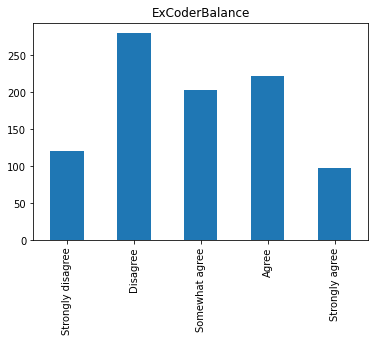

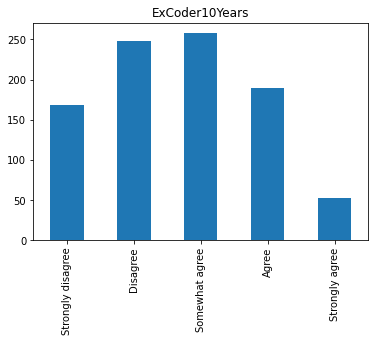

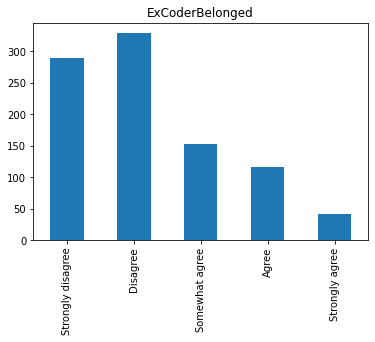

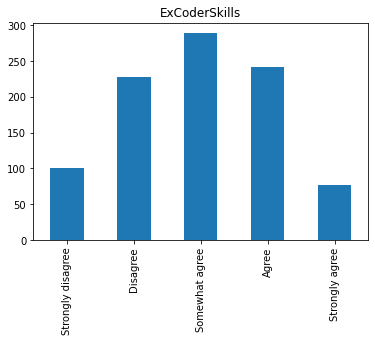

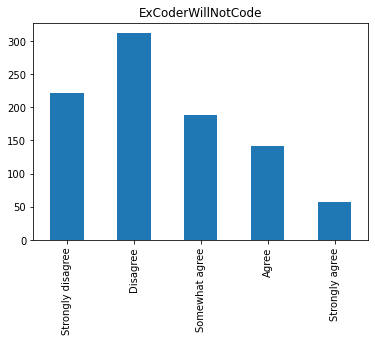

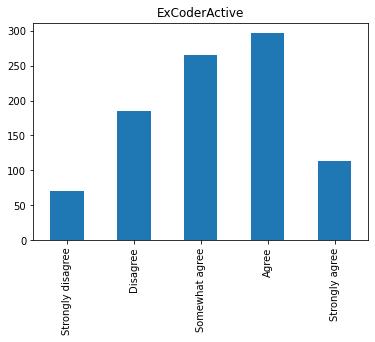

In [98]:
for col in df3.columns:
    df3[col].value_counts(sort=False).plot.bar()
    plt.title(col)
    plt.show()

In [68]:
df3.head(2)

,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive
12,Agree,Strongly disagree,Disagree,Strongly disagree,Disagree,Strongly disagree,Disagree,Somewhat agree
46,Agree,Disagree,Agree,Somewhat agree,Strongly disagree,Somewhat agree,Somewhat agree,Agree


In [58]:
df4 = df3.copy()
for col in df4.columns:
    df4[col] = df4[col].map({'Strongly disagree': 0,
            'Disagree': 1,
            'Somewhat agree': 2,
            'Agree': 3,
            'Strongly agree': 4}).astype(float)
df4['Not for me'] = df4[['ExCoderNotForMe', 'ExCoderWillNotCode']].mean(axis=1)
df4.drop(['ExCoderNotForMe', 'ExCoderWillNotCode'], axis=1, inplace=True)
df4.head()

,ExCoderReturn,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderActive,Not for me
12,3.0,1.0,0.0,1.0,0.0,2.0,0.5
46,3.0,3.0,2.0,0.0,2.0,3.0,1.5
197,2.0,3.0,3.0,0.0,1.0,1.0,1.0
266,1.0,3.0,0.0,1.0,1.0,3.0,3.0
309,1.0,1.0,0.0,4.0,1.0,2.0,2.5


In [116]:
df4.mean().sort_values(ascending=False)

ExCoderActive      2.212903
ExCoderReturn      2.138678
ExCoderSkills      1.963636
ExCoderBalance     1.885157
ExCoder10Years     1.685932
Not for me         1.252132
ExCoderBelonged    1.235991
dtype: float64

### <br>Conlusions
From this analysis, the main causes for leaving this field are:
1. **Earn more**
2. **Not enough skilled**
3. **More balanced life**

At the opposite side, people don't think to have choosen the wrong  
job. Almost nobody believe that coding was the wrong choice for them.  
Also the feeling to not belonging with the colleagues seems less   
shared. Furthermore, the most part of these developers still belong  
to the dveloper community (but this last information is less real in  
this dataset because these people writes on StackOverflow, so they  
are self-selected and less reppresentative of the population).

I've intentionally ignored the variables, between these, which not  
reppresent causes for leaving the job.

Let's plot these findings:

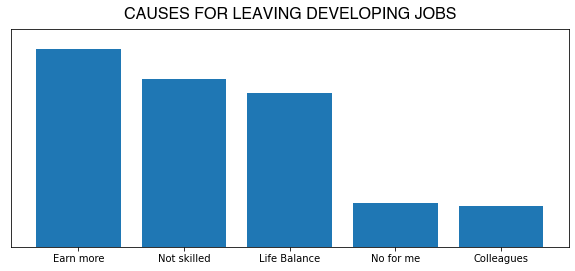

In [60]:
table = df4.drop(['ExCoderActive',
                  'ExCoder10Years'], axis=1).mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(table.index, table)
ax.set_xticks(range(table.shape[0]))
ax.set_xticklabels(['Earn more',
                    'Not skilled',
                    'Life Balance',
                    'No for me',
                    'Colleagues'])
ax.set_yticks([])
ax.set_ylim(1, 2.25)
ax.set_title('CAUSES FOR LEAVING DEVELOPING JOBS', y=1.02,
             fontweight='bold', fontdict={'family':'Helvetica'},
             size=16)
fig.savefig('plots/leaving code.png')
plt.show()

## 3. What are the main profiles for people who posts on StackOverflow?

In order to accomplish this question, we will proceed with the  
following steps:  
1. We must **preprocess** many columns:  
    1.1 Ordinal columns -->  They will be converted to numerical  
    1.2 Text columns --> They will be converted into dummies  
    1.3 Complex text columns  -->  They will be converted into dummies  
2. We will try to fill or drop the **NAs**
3. We will consider if the number of final columns would be too big,  
   in relation with the number of samples kept. If so, we will  
   eliminate some columns (maybe some complex text column which  
   generates many dummies)
4. We will look for **natural big clusters**, if any. We will investigate  
   in two ways:  
   4.1  **T-SNE**: 2-dimensional visual reppresentation of the data, to  
          look for natural clusters graphically3  
   2.2  **K-Means**: We will try using the elbow method to look for clusters
   
The first steps are about preprocessing:

In [66]:
# Example of one column
df['StackOverflowCompanyPage'].value_counts()

Haven't done at all        26263
Once or twice               4323
Several times               2201
At least once each week      512
At least once each day       136
Name: StackOverflowCompanyPage, dtype: int64

In [58]:
df.head(3)

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,[nan],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stac...,9.0,Desktop; iOS app,At le

In [15]:
# Grouping columns by type.
# For the ordinal columns, I've created a group for every different  
# encoding they use, in order to better preprocess them.

ordinal_1_columns = ['ProblemSolving',
                     'BuildingThings',
                     'LearningNewTech',
                     'BoringDetails',
                     'JobSecurity',
                     'DiversityImportant',
                     'AnnoyingUI',
                     'FriendsDevelopers',
                     'RightWrongWay',
                     'UnderstandComputers',
                     'SeriousWork',
                     'InvestTimeTools',
                     'WorkPayCare',
                     'KinshipDevelopers',
                     'ChallengeMyself',
                     'CompetePeers',
                     'ChangeWorld',
                     'ShipIt',
                     'OtherPeoplesCode',
                     'ProjectManagement',
                     'EnjoyDebugging',
                     'InTheZone',
                     'DifficultCommunication',
                     'CollaborateRemote',
                     'StackOverflowAdsRelevant',
                     'StackOverflowAdsDistracting',
                     'StackOverflowModeration',
                     'StackOverflowCommunity',
                     'StackOverflowHelpful',
                     'StackOverflowBetter',
                     'StackOverflowWhatDo',
                     'StackOverflowMakeMoney',
                     'SurveyLong',
                     'QuestionsInteresting',
                     'QuestionsConfusing',
                     'InterestedAnswers',
                     'SurveyLong']

ordinal_2_columns = ['AssessJobIndustry',
                     'AssessJobRole',
                     'AssessJobExp',
                     'AssessJobDept',
                     'AssessJobTech',
                     'AssessJobProjects',
                     'AssessJobCompensation',
                     'AssessJobOffice',
                     'AssessJobCommute',
                     'AssessJobRemote',
                     'AssessJobLeaders',
                     'AssessJobProfDevel',
                     'AssessJobDiversity',
                     'AssessJobProduct',
                     'AssessJobFinances',
                     'ImportantHiringAlgorithms',
                     'ImportantHiringTechExp',
                     'ImportantHiringCommunication',
                     'ImportantHiringOpenSource',
                     'ImportantHiringPMExp',
                     'ImportantHiringCompanies',
                     'ImportantHiringTitles',
                     'ImportantHiringEducation',
                     'ImportantHiringRep',
                     'ImportantHiringGettingThingsDone']

ordinal_3_columns = ['EquipmentSatisfiedMonitors',
                     'EquipmentSatisfiedCPU',
                     'EquipmentSatisfiedRAM',
                     'EquipmentSatisfiedStorage',
                     'EquipmentSatisfiedRW',
                     'InfluenceInternet']

ordinal_4_columns = ['InfluenceWorkstation',
                     'InfluenceHardware',
                     'InfluenceServers',
                     'InfluenceTechStack',
                     'InfluenceDeptTech',
                     'InfluenceVizTools',
                     'InfluenceDatabase',
                     'InfluenceCloud',
                     'InfluenceConsultants',
                     'InfluenceRecruitment',
                     'InfluenceCommunication']

ordinal_5_columns = ['StackOverflowFoundAnswer',
                     'StackOverflowCopiedCode',
                     'StackOverflowJobListing',
                     'StackOverflowCompanyPage',
                     'StackOverflowJobSearch',
                     'StackOverflowNewQuestion',
                     'StackOverflowAnswer',
                     'StackOverflowMetaChat']

complex_text_columns = ['ImportantBenefits',
                        'JobProfile',
                        'EducationTypes',
                        'SelfTaughtTypes',
                        'CousinEducation',
                        'HaveWorkedLanguage',
                        'WantWorkLanguage',
                        'HaveWorkedFramework',
                        'WantWorkFramework',
                        'HaveWorkedDatabase',
                        'WantWorkDatabase',
                        'HaveWorkedPlatform',
                        'WantWorkPlatform',
                        'IDE',
                        'Methodology',
                        'MetricAssess',
                        'StackOverflowDevices',
                        'DeveloperType',
                        'Gender']

dummy_columns = ['Professional',
                 'ProgramHobby',
                 'University',
                 'EmploymentStatus',
                 'MajorUndergrad',
                 'HomeRemote',
                 'JobSeekingStatus',
                 'LastNewJob',
                 'ClickyKeys',
                 'TabsSpaces',
                 'AuditoryEnvironment',
                 'VersionControl',
                 'CheckInCode',
                 'Race',
                 'Country']

columns_drop = ['Respondent',
                'CompanyType',
                'YearsProgram',
                'YearsCodedJobPast',
                'WebDeveloperType',
                'MobileDeveloperType',
                'NonDeveloperType',
                'CareerSatisfaction',
                'ExCoderReturn',
                'ExCoderNotForMe',
                'ExCoderBalance',
                'ExCoder10Years',
                'ExCoderBelonged',
                'ExCoderSkills',
                'ExCoderWillNotCode',
                'ExCoderActive',
                'PronounceGIF',
                'LearnedHiring',
                'ResumePrompted',
                'LearnedHiring',
                'Currency',
                'Overpaid',
                'EducationImportant',
                'TimeAfterBootcamp',
                'WorkStart',
                'StackOverflowDescribes',
                'SurveyLong']

In [5]:
# Just an example of encoding for Ordinal columns
df['RightWrongWay'].value_counts()

Somewhat agree       9894
Disagree             7697
Agree                7073
Strongly agree       4020
Strongly disagree    2300
Name: RightWrongWay, dtype: int64

In [8]:
def create_dummies(df, col):
    """This function can reclassify a column stored as strings with
    multiple informations chained.
    
    Parameters
    ------------
    df : pandas.DataFrame
      The dataframe with the column to be analysed.
    
    col : str
      The name of the column in df.
    
    Returns
    ------------
    df : pandas.DataFrame
      The initial df but with the original "col" column substituted  
      with dummies.
    """
    
    df = df.copy()
    diz = set()
    new_column = list()
    
    for string in df[col]:
        values = str(string).split(';')
        sublist = []
        for val in values:
            diz.add(val)
            sublist.append(val.strip())
        new_column.append(sublist)
        
    df[col] = new_column
    
    for val in diz:
        df[col + '_' + val] = val in df[col]
    df.drop(col, axis=1, inplace=True)
    
    return df

In [74]:
# Preprocess df

df4 = df.copy()

# Ordinal 1 columns
print('ORDINAL 1')
col_map = {'Strongly disagree': 0,
           'Disagree': 1,
           'Somewhat agree': 2,
           'Agree': 3,
           'Strongly agree': 4}
for col in ordinal_1_columns:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

# Ordinal 2 columns
print('\nORDINAL 2')
col_map = {'Not at all important': 0,
           'Not very important': 1,
           'Somewhat important': 2,
           'Important': 3,
           'Very important': 4}
for col in ordinal_2_columns:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

# Ordinal 3 columns
print('\nORDINAL 3')
col_map = {'Not at all satisfied': 0,
           'Not very satisfied': 1,
           'Somewhat satisfied': 2,
           'Satisfied': 3,
           'Very satisfied': 4}
for col in ordinal_3_columns:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

# Ordinal 4 columns
print('\nORDINAL 4')
col_map = {'No influence at all': 0,
           'Not much influence': 1,
           'Some influence': 2,
           'A lot of influence': 3,
           'I am the final decision maker': 4}
for col in ordinal_4_columns:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

# Ordinal 5 columns
print('\nORDINAL 5')
col_map = {'Haven\'t done at all': 0,
           'Once or twice': 1,
           'At least once each week': 2,
           'At least once each day': 3,
           'Several times': 4}
for col in ordinal_5_columns:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

# Other Ordinal columns

col_map = {'I never completed any formal education': 0,
           'Primary/elementary school': 1,
           'Secondary school': 2,
           'Professional degree': 3,
           "Some college/university study without earning a bachelor's degree": 4,
           "Bachelor's degree": 5,
           'Doctoral degree': 6,
           "Master's degree": 6,
           'I prefer not to answer': np.nan}
for col in ['FormalEducation']:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

col_map = {'No education': 0,
           'Primary/elementary school': 1,
           'High school': 2,
           'A professional degree': 3,
           "Some college/university study, no bachelor's degree": 4,
           "A bachelor's degree": 5,
           'A doctoral degree ': 6,
           "A master's degree": 6,
           'I prefer not to answer': np.nan,
           "I don't know/not sure": np.nan}
for col in ['HighestEducationParents']:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

col_map = {'Fewer than 10 employees': 1,
           '10 to 19 employees': 2,
           '20 to 99 employees': 3,
           '100 to 499 employees': 4,
           '500 to 999 employees': 5,
           "1,000 to 4,999 employees": 6,
           '5,000 to 9,999 employees': 7,
           '10,000 or more employees': 8,
           "I don't know": np.nan,
           'I prefer not to answer': np.nan}
for col in ['CompanySize']:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

col_map = {'Less than a year': 1,
           '1 to 2 years': 2,
           '2 to 3 years': 3,
           '3 to 4 years': 4,
           '4 to 5 years': 4,
           '5 to 6 years': 4,
           '6 to 7 years': 5,
           '7 to 8 years': 5,
           '8 to 9 years': 5,
           '9 to 10 years': 5,
           '10 to 11 years': 6,
           '11 to 12 years': 6,
           '12 to 13 years': 6,
           '13 to 14 years': 6,
           '14 to 15 years': 6,
           '15 to 16 years': 7,
           '16 to 17 years': 7,
           '17 to 18 years': 7,
           '18 to 19 years': 7,
           '19 to 20 years': 7,
           '20 or more years': 7}
for col in ['YearsCodedJob']:
    print('Column {} had initially {} distinct values.'.format(
        col, len(df4[col].unique())))
    df4[col] = df4[col].map(col_map).astype(float)
    print('Column {} has now {} distinct values.'.format(
        col, len(df4[col].unique())))

# Complex text columns
print('\nCOMPLEX TEXT COLUMNS')
col_map = {'Haven\'t done at all': 0,
           'Once or twice': 1,
           'At least once each week': 2,
           'At least once each day': 3,
           'Several times': 4}
for col in complex_text_columns:
    print('Before splitting column {} df4 had initially {} columns.'.format(
        col, df4.shape[1]))
    df4 = create_dummies(df4, col=col)
    print('Before splitting column {} df4 has now {} columns.'.format(
        col, df4.shape[1]))

# Regular nominal columns
print('\nREGULAR1 TEXT COLUMNS')
country_keep = df['Country'].value_counts()[:20].index
df4.loc[~df4.Country.isin(country_keep), 'Country'] = 'Other'
df4 = pd.get_dummies(df4, columns=dummy_columns)
for col in dummy_columns: print(f'{col} RICLASSIFIED')

# Drop useless columns
df4.drop(columns=columns_drop, axis=1, inplace=True)

ORDINAL 1
Column ProblemSolving had initially 6 distinct values.
Column ProblemSolving has now 6 distinct values.
Column BuildingThings had initially 6 distinct values.
Column BuildingThings has now 6 distinct values.
Column LearningNewTech had initially 6 distinct values.
Column LearningNewTech has now 6 distinct values.
Column BoringDetails had initially 6 distinct values.
Column BoringDetails has now 6 distinct values.
Column JobSecurity had initially 6 distinct values.
Column JobSecurity has now 6 distinct values.
Column DiversityImportant had initially 6 distinct values.
Column DiversityImportant has now 6 distinct values.
Column AnnoyingUI had initially 6 distinct values.
Column AnnoyingUI has now 6 distinct values.
Column FriendsDevelopers had initially 6 distinct values.
Column FriendsDevelopers has now 6 distinct values.
Column RightWrongWay had initially 6 distinct values.
Column RightWrongWay has now 6 distinct values.
Column UnderstandComputers had initially 6 distinct valu

In [13]:
# An example of a column preprocessed, compared with the original one

col = 'Gender'
print(analyse_column(df, col=col, recreate_column=False, column_distribution=True))
print('\n\n')
print(df[col].value_counts(dropna=False))

Male                     31890
nan                      16345
Female                    2743
Gender non-conforming      314
Other                      428
Transgender                180
dtype: int64



Male                                                       31589
NaN                                                        16345
Female                                                      2600
Other                                                        225
Male; Other                                                  171
Gender non-conforming                                        160
Male; Gender non-conforming                                   65
Female; Transgender                                           56
Transgender                                                   55
Female; Gender non-conforming                                 29
Transgender; Gender non-conforming                            15
Male; Female; Transgender; Gender non-conforming; Other       15
Male; Female      

In [100]:
df4.head()

,FormalEducation,CompanySize,YearsCodedJob,JobSatisfaction,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,HoursPerWeek,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowSatisfaction,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,HighestEducationParents,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary,ImportantBenefits_Meals,ImportantBenefits_ Remote options,ImportantBenefits_ Professional development sponsorship,ImportantBenefits_ Long-term leave,ImportantBenefits_Stock options,ImportantBenefits_ Vacation/days off,ImportantBenefits_Expected work hours,ImportantBenefits_None of these,ImportantBenefits_Education sponsorship,ImportantBenefits_Child/elder care,ImportantBenefits_ Health benefits,ImportantBenefits_ Expected work hours,ImportantBenefits_ Charitable match,ImportantBenefits_ Annual bonus,ImportantBenefits_Long-term leave,ImportantBenefits_ Equipment,ImportantBenefits_Health benefits,ImportantBenefits_Retirement,ImportantBenefits_ Other,ImportantBenefits_ Private office,ImportantBenefits_ Retirement,ImportantBenefits_Equipment,ImportantBenefits_ Education sponsorship,ImportantBenefits_ None of these,ImportantBenefits_Annual bonus,ImportantBenefits_Professional development sponsorship,ImportantBenefits_Private office,ImportantBenefits_Charitable match,ImportantBenefits_ Child/elder care,ImportantBenefits_Vacation/days off,ImportantBenefits_Other,ImportantBenefits_Remote options,ImportantBenefits_nan,ImportantBenefits_ Meals,JobProfile_ Pracuj,JobProfile_Pracuj,JobProfile_ Glassdoor,JobProfile_LinkedIn,JobProfile_ Hired.com,JobProfile_Talent.io,JobProfile_Xing,JobProfile_ Remix_jobs,JobProfile_Naukri,JobProfile_Remix_jobs,JobProfile_ Reed.co.uk,JobProfile_Hired.com,JobProfile_ Indeed,JobProfile_ Naukri,JobProfile_ Workopolis,JobProfile_Indeed,JobProfile_ Xing,JobProfile_Total_Jobs,JobProfile_Dice,JobProfile_ Other,JobProfile_ TripleByte,JobProfile_ Monster,JobProfile_ Total_Jobs,JobProfile_ JobSite.co.uk,JobProfile_ StepStone,JobProfile_ LinkedIn,JobProfile_Monster,JobProfile_TripleByte,JobProfile_JobSite.co.uk,JobProfile_ Talent.io,JobProfile_StepStone,JobProfile_CW_Jobs,JobProfile_Workopolis,JobProfile_Reed.co.uk,JobProfile_Other,JobProfile_nan,JobProfile_ Dice,JobProfile_Glassdoor,EducationTypes_Coding competition,EducationTypes_ On-the-job training,EducationTypes_Bootcamp,EducationTypes_Part-time/evening course,EducationTypes_ Bootcamp,EducationTypes_ Industry certification,EducationTypes_On-the-job training,EducationTypes_Open source contributions,EducationTypes_ Hac

In [101]:
df4.shape

(51392, 856)

Now that the data are almost ready, we will:
1. **Subsample** the data in order to improve graphical readibility  
2. **Scale** the data in order to improve subsequent model  
3. **Transform** the data with the a T-SNE model
4. **Plot** transformed data

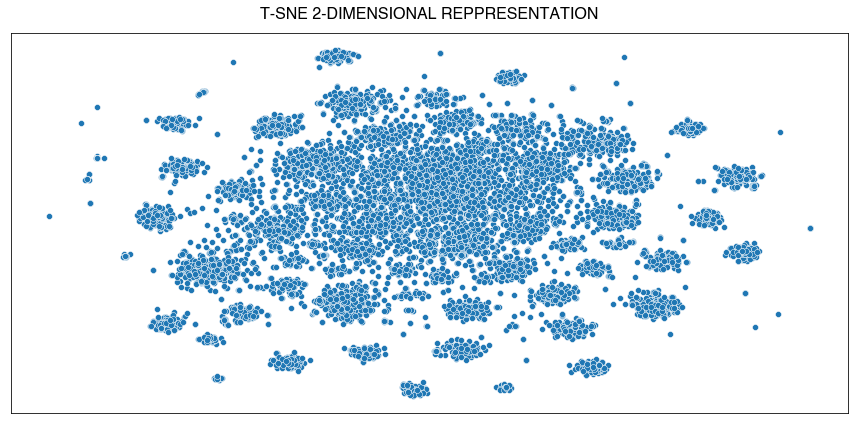

In [95]:
# This step is just to subsample data
subset = df4.sample(10000, random_state=10)

# Fill NAs with the mean of each columns
subset.fillna(subset.mean(), inplace=True)

# Scale the data
scaler = StandardScaler()
subset = scaler.fit_transform(subset)

# Transform the data
tsne = TSNE(n_components=2, random_state=10, learning_rate=50)
X_2d = tsne.fit_transform(subset)

# Plot the transformed data
fix, ax = plt.subplots(figsize=(15,7))
ax.scatter(X_2d[:, 0], X_2d[:, 1], edgecolors='w', linewidths=0.5)
ax.set_title('T-SNE 2-DIMENSIONAL REPPRESENTATION', size=16, y=1.02,
             fontdict={'family': 'Helvetica'})
ax.set_xticks([])
ax.set_yticks([])
plt.show()

**From this plot, there's no evidence of natual big clusters of users.**

THe evidence here is that thare a large number of small cluster of users.

Let's try to make a simplier model, dropping all columns with many  
NAs for example, which may lead to closer samples because if a huge  
number of features become equal to the mean, many individuals tend  
to be like each other, like the average individual.

Dropping many of these columns, it will be easier to have evidence  
of natural clusters, if any.

In [79]:
# Let's drop every columns with the number of NAs greater that 10%  
# of samples.
# Let's than compare the number of the original columns with the  
#  new one.
print(df4.shape)
df4.drop(
    columns=df4.columns[df4.isna().sum() > df4.shape[0] * 0.1],
    axis=1).shape

(51392, 837)


(51392, 744)

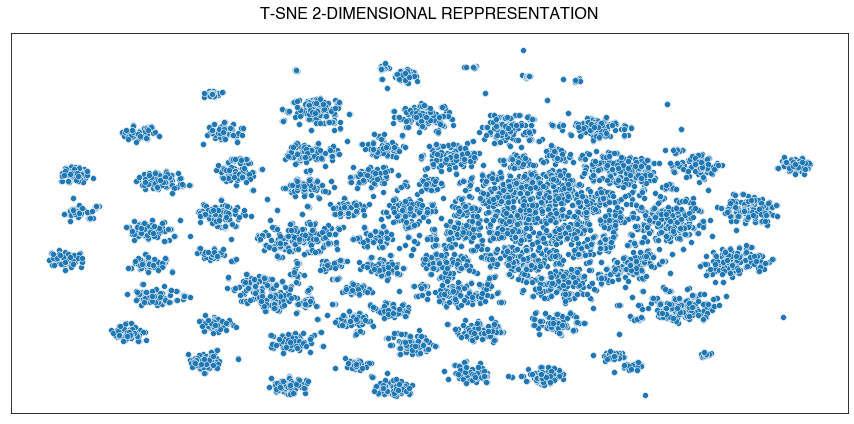

In [94]:
# Same process as above, but with less columns

subset = df4.sample(10000, random_state=10)
subset.fillna(subset.mean(), inplace=True)
subset = subset.drop(
    columns=df4.columns[df4.isna().sum() > df4.shape[0] * 0.1],
    axis=1)
scaler = StandardScaler()
subset = scaler.fit_transform(subset)
tsne = TSNE(n_components=2, random_state=10, learning_rate=50)
X_2d = tsne.fit_transform(subset)

fix, ax = plt.subplots(figsize=(15,7))
ax.scatter(X_2d[:, 0], X_2d[:, 1], edgecolors='w', linewidths=0.5)
ax.set_title('T-SNE 2-DIMENSIONAL REPPRESENTATION', size=16, y=1.02,
             fontdict={'family': 'Helvetica'})
ax.set_xticks([])
ax.set_yticks([])
plt.show()

No relevant differences from the first picture, apart the fact that  
now the central part of the plot is less omogeneous, as we expected.  
We conclude that there are no natural big clusters in this dataset,  
but a number of small clusters, which we will not study now.

We can try another approach to identify possible clusters: **K-Means**.  
We will make an elbow plot to identify the number of natural clusters  
if any.

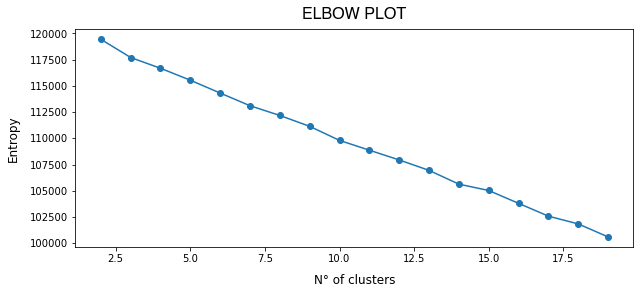

In [93]:
subset = df4.sample(1000, random_state=10)
subset.fillna(subset.mean(), inplace=True)
subset = subset.drop(
    columns=df4.columns[df4.isna().sum() > df4.shape[0] * 0.1],
    axis=1)
scaler = StandardScaler()
subset = scaler.fit_transform(subset)

entropy = []
for k in range(2, 20):
    km = KMeans(n_clusters=k)
    km.fit(subset)
    entropy.append(km.inertia_)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(range(2, 20),
        entropy,
        marker='o')
ax.set_title('ELBOW PLOT', size=16, y=1.02,
             fontdict={'family': 'Helvetica'})
ax.set_xlabel('N° of clusters', labelpad=10, size=12)
ax.set_ylabel('Entropy', labelpad=10, size=12)
plt.show()

Also this approach leads to no natuaral clusters for this dataset,  
beacuse there isn't any "elbow" in the plot above.

### <br>Conlusions
We can't identify big natural clusters in this datasets, so there  
aren't particular user profiles to examinate, but we can conlude  
that we have a great variety of users in this dataset.  
From the T-SNE 2-dimensional reppresentaion, we may think that  
the great number of small clusters could be the consequence of a  
particular sampling design made by StackOverflow in order to choose  
the users to be interviwed. Maybe a stratified sampling. This is  
just my thought, I have no idea if this was true or not.